In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'
tools_path = '../helperScripts/tools.py'
# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [4]:
## load data for the roi of interest    
roi_of_interest = 'roi_2'

# load the sg_object
with open(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [5]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [6]:
df['cell_id'] = [str(id) for id in df['object_id']]

# sg_obj.gdf['cell_id'] = [str(x) for x in sg_obj.gdf['object_id']]
sg_obj.gdf['object_id'] = sg_obj.gdf.index
sg_obj.gdf['cell_id'] = sg_obj.gdf['object_id'].astype('string')
sg_obj.gdf.index.name = 'index'
sg_obj.gdf = sg_obj.gdf.sort_values('object_id')

# assign clusters to the sg_obj
sg_obj.gdf = sg_obj.gdf.merge(df[['cell_id']+list(df.columns.difference(sg_obj.gdf.columns))],on=['cell_id'],how='left')

In [7]:
merged_gdf = sg_obj.gdf

In [8]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

adata_genes = sc.AnnData(df[gene_cols])

obs_cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes'] + cols_to_keep 

adata_genes.obs = df[obs_cols]

adata_genes.obs.index = [str(x) for x in adata_genes.obs.index]

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_50897/749676134.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes = sc.AnnData(df[gene_cols])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Metrics based on filtering by 3 barcodes per cluster
Average cells per cluster 11.11659513590844
Number of clusters 1398
Metrics based on additionally filtering by 10 cells per cluster
Average cells per cluster 70.83707865168539
Number of clusters 178


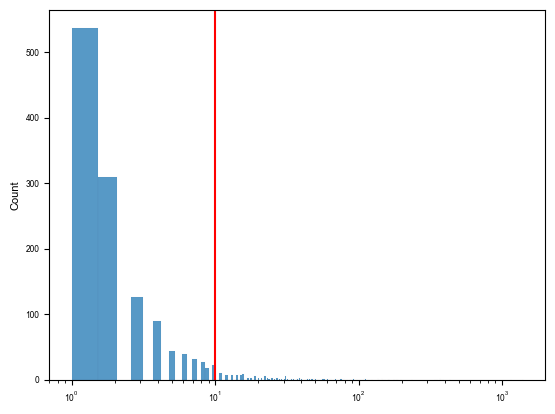

In [9]:
n_bcs_per_cluster_cutoff = 3
# n_cells_per_cluster_cutoff = 5
n_cells_per_cluster_cutoff = 10

# using the clustering to call clones
confident_clusters = adata_genes[adata_genes.obs['bc_cluster_n_bcs'] >= n_bcs_per_cluster_cutoff]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)

print(f'Metrics based on filtering by {n_bcs_per_cluster_cutoff} barcodes per cluster')
print('Average cells per cluster',np.mean(cluster_sizes))
print('Number of clusters',len(cluster_names))

sns.histplot(cluster_sizes)
plt.axvline(n_cells_per_cluster_cutoff,color='r')
plt.xscale('log')

# large enough clusters
large_clusters = cluster_names[cluster_sizes >= n_cells_per_cluster_cutoff]

confident_clusters = adata_genes[adata_genes.obs['bc_cluster'].isin(large_clusters)]

cluster_names, cluster_sizes = np.unique(confident_clusters.obs['bc_cluster'],return_counts=True)
# sns.histplot(cluster_sizes)

print(f'Metrics based on additionally filtering by {n_cells_per_cluster_cutoff} cells per cluster')
print('Average cells per cluster',np.mean(cluster_sizes))
print('Number of clusters',len(cluster_names))


In [10]:
np.unique(confident_clusters.obs['bc_cluster'].values)

array([   8.,   10.,   15.,   16.,   17.,   20.,   21.,   28.,   31.,
         35.,   41.,   42.,   47.,   49.,   51.,   53.,   62.,   71.,
         72.,   78.,   79.,   83.,   92.,   93.,   98.,  102.,  106.,
        109.,  112.,  121.,  138.,  146.,  157.,  165.,  167.,  170.,
        173.,  175.,  177.,  189.,  195.,  196.,  201.,  203.,  204.,
        207.,  214.,  218.,  220.,  222.,  225.,  228.,  233.,  237.,
        238.,  247.,  253.,  259.,  263.,  266.,  268.,  270.,  274.,
        284.,  288.,  299.,  308.,  309.,  318.,  319.,  323.,  332.,
        334.,  338.,  339.,  342.,  345.,  346.,  349.,  369.,  371.,
        372.,  374.,  384.,  391.,  394.,  397.,  400.,  404.,  406.,
        407.,  411.,  415.,  420.,  431.,  465.,  472.,  475.,  478.,
        490.,  511.,  514.,  527.,  537.,  539.,  548.,  553.,  557.,
        564.,  574.,  614.,  622.,  624.,  630.,  638.,  644.,  651.,
        652.,  657.,  672.,  680.,  681.,  691.,  720.,  722.,  726.,
        739.,  741.,

In [11]:
confident_clusters_gdf = sg_obj.gdf[sg_obj.gdf['bc_cluster'].isin(confident_clusters.obs['bc_cluster'].values)]

In [12]:
confident_clusters_gdf

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
6,"POLYGON ((33928.000 9633.000, 33942.000 9635.0...","POLYGON ((33924.838 9623.513, 33915.838 9626.5...",POINT (33945.759 9675.416),33945.759162,9675.415681,8488.228745,10002,10002,0.0,0.0,...,0.0,9.0,0.0,0.0,845.0,bc_002-bc_004-bc_094,"['bc_002', 'bc_004', 'bc_094']",3.0,"['bc_002', 'bc_004', 'bc_094']",3
11,"POLYGON ((35965.000 9635.000, 35993.000 9637.0...","POLYGON ((35888.038 9755.805, 35889.191 9757.2...",POINT (35971.499 9701.483),35971.498673,9701.483157,18641.260537,10007,10007,2.0,0.0,...,0.0,0.0,0.0,0.0,548.0,bc_009-bc_014-bc_021,"['bc_009', 'bc_014', 'bc_021']",3.0,"['bc_009', 'bc_014', 'bc_019', 'bc_021']",4
14,"POLYGON ((12996.000 2958.000, 13010.000 2959.0...","POLYGON ((12979.064 3029.186, 12979.333 3029.4...",POINT (13001.707 2992.839),13001.706631,2992.839302,6153.822805,1001,1001,2.0,0.0,...,0.0,0.0,0.0,0.0,537.0,bc_001-bc_005-bc_025-bc_030,"['bc_001', 'bc_005', 'bc_025', 'bc_030']",4.0,"['bc_001', 'bc_025', 'bc_030']",3
18,"POLYGON ((19185.000 9637.000, 19201.000 9638.0...","POLYGON ((19181.390 9627.674, 19150.390 9639.6...",POINT (19188.053 9702.727),19188.053031,9702.727225,14807.975005,10013,10013,3.0,0.0,...,0.0,0.0,16.0,0.0,1190.0,bc_003-bc_076-bc_095,"['bc_003', 'bc_076', 'bc_095']",3.0,"['bc_003', 'bc_076', 'bc_095']",3
20,"POLYGON ((30631.000 9638.000, 30646.000 9640.0...","POLYGON ((30558.529 9732.873, 30562.700 9735.4...",POINT (30615.295 9688.707),30615.294706,9688.706524,11836.997397,10015,10015,0.0,0.0,...,0.0,0.0,0.0,0.0,138.0,bc_025-bc_039-bc_047-bc_058-bc_059-bc_076-bc_079,"['bc_025', 'bc_039', 'bc_047', 'bc_058', 'bc_0...",7.0,"['bc_025', 'bc_040', 'bc_047', 'bc_059', 'bc_0...",6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67176,"POLYGON ((19349.000 9618.000, 19360.000 9618.0...","POLYGON ((19348.445 9608.015, 19330.445 9609.0...",POINT (19329.817 9668.821),19329.817473,9668.821226,12284.464291,9976,9976,0.0,0.0,...,0.0,0.0,13.0,0.0,1190.0,bc_003-bc_076-bc_095,"['bc_003', 'bc_076', 'bc_095']",3.0,"['bc_003', 'bc_013', 'bc_076', 'bc_095']",4
67180,"POLYGON ((15698.000 2956.000, 15711.000 2956.0...","POLYGON ((15694.061 2946.809, 15680.061 2952.8...",POINT (15702.937 2988.794),15702.936864,2988.793734,5499.612463,998,998,1.0,0.0,...,0.0,0.0,0.0,0.0,2386.0,bc_025-bc_060-bc_062-bc_066,"['bc_025', 'bc_060', 'bc_062', 'bc_066']",4.0,"['bc_025', 'bc_060', 'bc_062', 'bc_066']",4
67187,"POLYGON ((30315.000 9623.000, 30332.000 9623.0...","POLYGON ((30288.075 9719.483, 30288.338 9719.9...",POINT (30351.533 9684.110),30351.533431,9684.109860,18563.854953,9986,9986,1.0,0.0,...,0.0,0.0,0.0,0.0,138.0,bc_025-bc_039-bc_047-bc_058-bc_059-bc_076-bc_079,"['bc_025', 'bc_039', 'bc_047', 'bc_058', 'bc_0...",7.0,"['bc_025', 'bc_039', 'bc_047', 'bc_058', 'bc_0...",8
67189,"POLYGON ((36956.000 9625.000, 36976.000 9626.0...","POLYGON ((36941.576 9622.135, 36941.294 9622.0...",POINT (36965.342 9653.127),36965.342480,9653.126698,5465.866622,9988,9988,2.0,0.0,...,0.0,0.0,0.0,0.0,548.0,bc_009-bc_014-bc_021,"['bc_009', 'bc_014', 'bc_021']",3.0,"['bc_009', 'bc_014']",2


In [13]:
### We can look at which clusters have the highest SFRP1 expression. Cluster 31 has the hightest.

confident_clusters_gdf.groupby(by='bc_cluster')['SFRP1'].mean().sort_values(ascending=False).head(10)

bc_cluster
31.0      3.379310
490.0     1.454545
41.0      0.692308
1136.0    0.571429
391.0     0.557377
253.0     0.529412
51.0      0.500000
415.0     0.479452
909.0     0.454545
1298.0    0.444444
Name: SFRP1, dtype: float64

In [14]:
## When we plotted Cluster 31, we noticed there were many neighboring cells that also expressed SFRP1. 
## We further manually annotated the cells in the neighborhood to ensure cells were correctly assigned to the cluster.

manual_annotation = pd.read_csv('../extractedData/cluster 31 manual annotation - manual_annotation_radius_large.csv')

manual_annotation= manual_annotation[manual_annotation['object_id'].notnull()]


In [15]:
manual_cluster = manual_annotation[((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['POSSIBLE','TRUE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['TRUE']))) |

                   ((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['TRUE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['POSSIBLE','TRUE']))) | 
                   
                   ((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['POSSIBLE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['POSSIBLE']))) 

                   ] 
                   

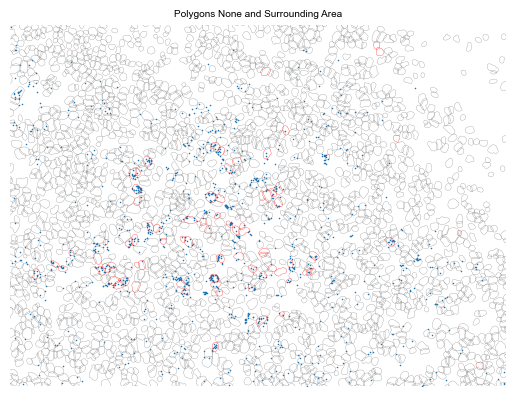

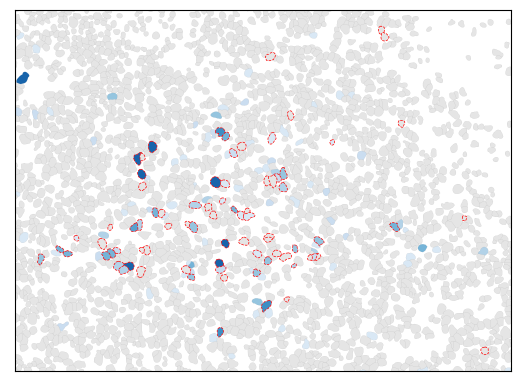

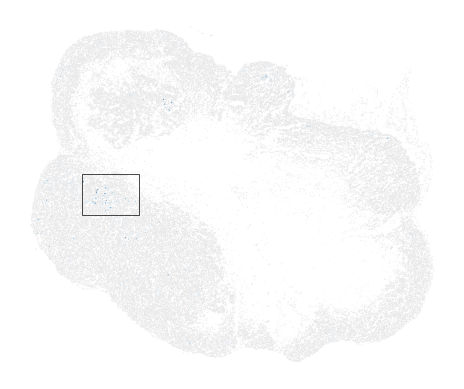

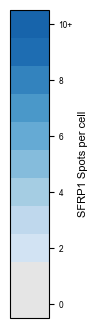

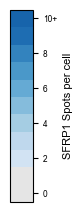

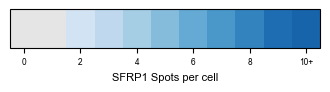

In [72]:
# gene_of_interest = 'VCAM1'
gene_of_interest = 'SFRP1'
# gene_of_interest = 'SPARC'
# gene_of_interest = 'SFRP1'
# gene_of_interest = 'FN1'
# gene_of_interest = 'BGN'
cluster_of_interest = 31

# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)

cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)

central_ix = int(len(cluster_cells)/2)

cell_id = cluster_cells[central_ix]

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=1,id_field='cell_id')

# sg_obj.gdf['object_id'] = sg_obj.gdf.index
# sg_obj.gdf['cell_id'] = sg_obj.gdf['cell_id'].astype('string')


# gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')


fig,ax = plt.subplots()
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                            color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.1,
                            focal_outline_color='r',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.2,
                            exterior_marker='.',marker_size=5,ax=ax)

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

plt.axis('off')
# plt.title()
plt.gca().invert_yaxis()

### PLOT THE ZOOMED IN IMAGE     
fig,ax = plt.subplots()

vmin = 2
vmax = 10

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

bbox = box(xmin,ymin,xmax,ymax)

other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

# other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

# new_cmap = cmap(np.linspace(0.5, 1, 256))

# cmap = matplotlib.cm.get_cmap('Greys').copy()
# cmap = cmap(np.linspace(0.1, 0.9, 256))

cmap = matplotlib.cm.get_cmap('Blues').copy()
cmap = cmap(np.linspace(0.15, 0.8, 256))

cmap = matplotlib.colors.ListedColormap(cmap)

# cmap.set_under('#F5F5F5')
cmap.set_under('#e5e5e5')
# cmap.set_under('#d9d9d9')
# cmap.set_under('#a9a9a9')

# print(merged_gdf_focal.shape)

# merged_gdf_other.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
#                 vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)
merged_gdf_other.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

# this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.5,linestyle='--')

# merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
#                 vmin=vmin,vmax=vmax,edgecolor='r',linewidth=0.75,linestyle='--')

# merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
#                 vmin=vmin,vmax=vmax,edgecolor='#2c7fb8',linewidth=0.75,linestyle='--')

# merged_gdf_focal.plot(column=gene_of_interest, cmap=cmap, legend=False, ax=ax,
#                 vmin=vmin,vmax=vmax,edgecolor='#feb24c',linewidth=0.5,linestyle='--')



# rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
# ax.add_patch(rect)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()

ax.set_xticks([])
ax.set_yticks([])
# ax.set_facecolor('#F5F5F5')

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_zoom.pdf',bbox_inches='tight')
# plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_zoom.pdf',bbox_inches='tight',transparent=True)
# plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_zoom_grayed.pdf',bbox_inches='tight')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_zoom_grayed.pdf',bbox_inches='tight')


### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
fig,ax = plt.subplots()

# ax = fig.add_subplot(223)

# merged_gdf.plot(column=gene_of_interest, cmap='Reds', legend=False,vmin=vmin,vmax=vmax,ax=ax,
#                 edgecolor='#d9d9d9',linewidth=0.0)
merged_gdf.plot(column=gene_of_interest, cmap=cmap, legend=False,vmin=vmin,vmax=vmax,ax=ax,
                edgecolor='#d9d9d9',linewidth=0.0)


# ax.set_facecolor('k')
rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

ax.set_facecolor('#F5F5F5')
# ax.set_xticks([])
# ax.set_yticks([])
plt.axis('off')
plt.gca().invert_yaxis()

# # plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_full.pdf',bbox_inches='tight')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_full_grayed.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_full_grayed.png',dpi=500,bbox_inches='tight',transparent=True)


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(0.5,4))
# cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
#                             norm=norm,
#                             orientation='vertical')
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])
# ax.set_yticks([x+0.5 for x in [0,2,4,6,8,10]],[0,2,4,6,8,10])

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_colorbar_grayed.pdf',bbox_inches='tight',transparent=True)


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(0.3,2.5))
# cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
#                             norm=norm,
#                             orientation='vertical')
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])
# ax.set_yticks([x+0.5 for x in [0,2,4,6,8,10]],[0,2,4,6,8,10])

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_colorbar_grayed.pdf',bbox_inches='tight',transparent=True)


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(4,0.5))
# cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
#                             norm=norm,
#                             orientation='vertical')
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax,clip=False)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,boundaries=[0]+list(np.arange(1,12,1)),ticks=[0,2,4,6,8,10],
                            norm=norm,
                            orientation='horizontal')
cb1.set_label('SFRP1 Spots per cell')

cb1.set_ticks([x+0.5 for x in [0,2,4,6,8,10]])
cb1.set_ticklabels(['0','2','4','6','8','10+'])
# ax.set_yticks([x+0.5 for x in [0,2,4,6,8,10]],[0,2,4,6,8,10])

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_colorbar_grayed_horizontal.pdf',bbox_inches='tight',transparent=True)




Entire Tumor
Mean SFRP1 epxression: 0.10002678491711556
Fraction of cells with SFRP1 > 1: 0.015088836641766613
number of cells total: 67202
number of cells with SFRP1 > 1: 1014
Neighbors
Mean SFRP1 expression: 0.17717842323651453
Fraction of cells with SFRP1 > 1: 0.033609958506224065
number of cells total: 2410
number of cells with SFRP1 > 1: 81
clone 31
Mean SFRP1 expression: 3.7468354430379747
Fraction of cells with SFRP1 > 1: 0.5822784810126582
number of cells total: 79
number of cells with SFRP1 > 1: 46


Text(0.5, 0, 'Proportion of cells in group (sorted)')

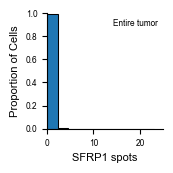

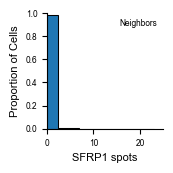

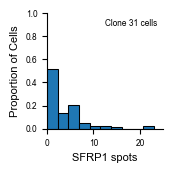

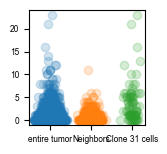

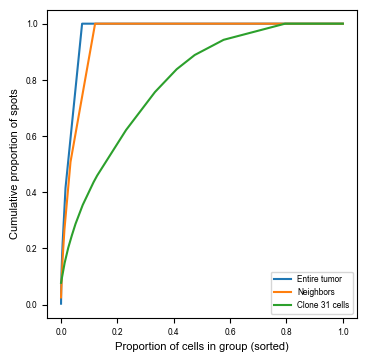

In [52]:
#### plot distributions of counts within the clone, compared to its neighborhood and the entire tumor 
# plt.subplots(figsize=(12,4),sharex=True,sharey=True)
# non_zero_cells = df[df['SFRP1']>1]
counts,bins = np.histogram(df['SFRP1'])

cluster_of_interest = 31

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# entire tumor
# ax = plt.subplot(1,3,3)
plt.text(s='Entire tumor',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Entire tumor')
sns.histplot(df['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_full.pdf',bbox_inches='tight',transparent=True)

print('Entire Tumor')
print('Mean SFRP1 epxression:',df['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1)/len(df))
print('number of cells total:',len(df))
print('number of cells with SFRP1 > 1:',np.sum(df['SFRP1']>1))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# neighbors
# ax = plt.subplot(1,3,2)
plt.text(s='Neighbors',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
# plt.title('Clone 31 neighboring cells')
sns.histplot(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_neighbors.pdf',bbox_inches='tight',transparent=True)

print('Neighbors')
print('Mean SFRP1 expression:',df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1)/len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
print('number of cells total:',len(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]))
print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]['SFRP1']>1))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()
# clone 31
# ax = plt.subplot(1,3,1)
plt.text(s='Clone 31 cells',x=0.95,y=0.95,ha='right',va='top',transform=ax.transAxes)
sns.histplot(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],bins=bins,alpha=1.0,stat='proportion',ax=ax)
plt.ylim(0,1)
plt.xlim(0,25)
plt.xlabel('SFRP1 spots')
plt.ylabel('Proportion of Cells')
ax.spines[['right', 'top']].set_visible(False)
# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_hists.pdf',bbox_inches='tight')
plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_hists_clone31.pdf',bbox_inches='tight',transparent=True)

print('clone 31')
print('Mean SFRP1 expression:',df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'].mean())
print('Fraction of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1)/len(df[df['object_id'].isin(manual_cluster['object_id'])]))
print('number of cells total:',len(df[df['object_id'].isin(manual_cluster['object_id'])]))
print('number of cells with SFRP1 > 1:',np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']>1))


fig,ax = plt.subplots(figsize=(1.5,1.5))

# entire tumor
ax.scatter([tools.jitter_point(0,0.1) for x in df['SFRP1']],
            df['SFRP1'],alpha=0.2)


# neighbors
neighbors = df[df['object_id'].isin([int(x) for x in merged_gdf_other['object_id']])]
ax.scatter([tools.jitter_point(1,0.1) for x in neighbors['SFRP1']],
            neighbors['SFRP1'],alpha=0.2)

# clone 31
ax.scatter([tools.jitter_point(2,0.1) for x in df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']],
            df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'],alpha=0.2)
# sns.histplot(,bins=bins,alpha=1.0,stat='proportion',ax=ax)

plt.xticks(range(3),['entire tumor','Neighbors','Clone 31 cells'])
# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_jitter.pdf',bbox_inches='tight')

fig,ax = plt.subplots(figsize=(4,4))
plt.plot(np.linspace(0,1,len(df['SFRP1'])),
         np.cumsum(df['SFRP1'].sort_values(ascending=False).values)/np.sum(df['SFRP1']),
         label='Entire tumor')
plt.plot(np.linspace(0,1,len(neighbors['SFRP1'])),
         np.cumsum(neighbors['SFRP1'].sort_values(ascending=False).values)/np.sum(neighbors['SFRP1']),
         label='Neighbors')
plt.plot(np.linspace(0,1,len(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'])),
         np.cumsum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1'].sort_values(ascending=False).values)/np.sum(df[df['object_id'].isin(manual_cluster['object_id'])]['SFRP1']),
         label='Clone 31 cells')
plt.legend()

plt.ylabel('Cumulative proportion of spots')
plt.xlabel('Proportion of cells in group (sorted)')



In [76]:
# plot SFRP1 spots for the whole roi

# open spots file
spots_df = pd.read_csv(tools.roi_file_paths[roi_of_interest]["spots_file"])

<Figure size 640x480 with 0 Axes>

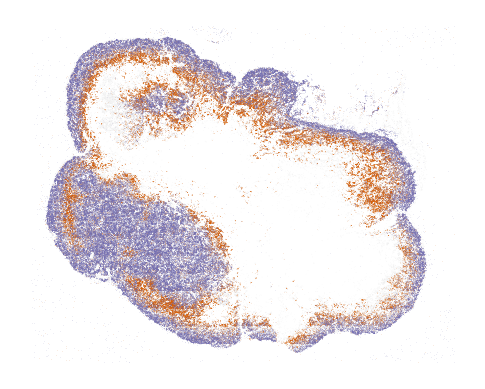

In [80]:
# plt.figure()
gene_of_interest = 'SFRP1'

gene_list = ['VEGFA',
             'MITF',
            #  'SPARC',
            'SFRP1',
                ]

gene_list = ['VEGFA',
             'MITF',
            #  'SPARC',
            # 'SFRP1',
                ]

gene_colors = {'VEGFA':'b',
               'MITF':'r',}

gene_colors = {
                # 'VEGFA':'#5e3c99',
               'VEGFA':'#d95f02',
               
            #    'MITF':'#e66101',
               'MITF':'#7570b3',
               
               }


plt.figure()
sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)

for gene_of_interest in gene_list:

    # get the spots for the gene of interest
    spots_gene = spots_df[spots_df['name']==gene_of_interest]

    plt.scatter(spots_gene['x'],spots_gene['y'],s=0.1,alpha=0.4,lw=0,color=gene_colors[gene_of_interest])

plt.axis('off')
# plt.title(gene_of_interest)
plt.gca().invert_yaxis()

plt.savefig(f'../graphs/space_VEGFA_MITF_full.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/space_VEGFA_MITF_full.png',dpi=500,bbox_inches='tight',transparent=True)

    

<Figure size 640x480 with 0 Axes>

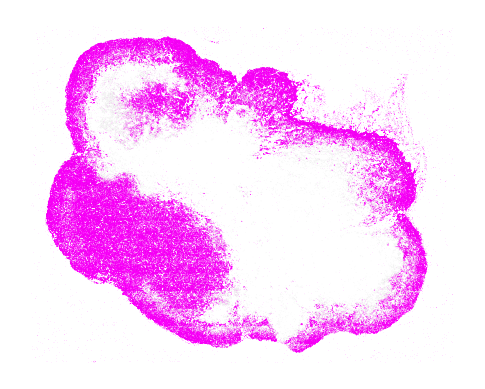

In [32]:
# plt.figure()
gene_of_interest = 'SFRP1'

gene_list = ['VEGFA',
             'MITF',
             'SPARC',
            'SFRP1',
                ]

gene_list = [
    # 'VEGFA',
#              'MITF',
             'SPARC',
            # 'SFRP1',
                ]

# gene_colors = {'VEGFA':'b',
#                'MITF':'r',}

gene_colors = {'SPARC':'magenta'}

plt.figure()
sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)

for gene_of_interest in gene_list:

    # get the spots for the gene of interest
    spots_gene = spots_df[spots_df['name']==gene_of_interest]

    plt.scatter(spots_gene['x'],spots_gene['y'],s=0.05,alpha=0.4,lw=0,color=gene_colors[gene_of_interest])

plt.axis('off')
# plt.title(gene_of_interest)
plt.gca().invert_yaxis()

# plt.savefig(f'../graphs/space_VEGFA_MITF_full.pdf',bbox_inches='tight',transparent=True)

    

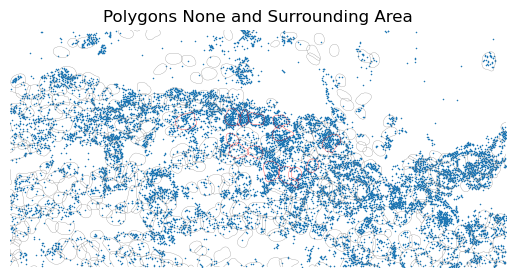

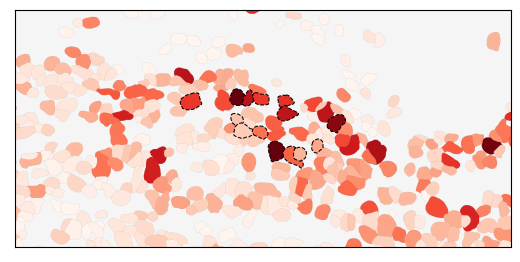

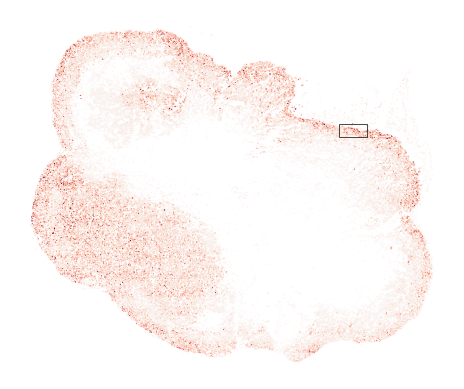

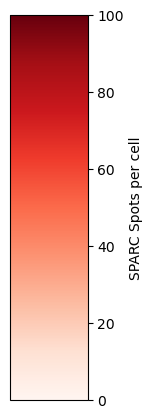

In [63]:
gene_of_interest = 'SPARC'
cluster_of_interest = 2472
# cluster_of_interest = 175
# cluster_of_interest = 1298

cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)

# cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)

central_ix = int(len(cluster_cells)/2)

cell_id = cluster_cells[central_ix]

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

# sg_obj.gdf['object_id'] = sg_obj.gdf.index
# sg_obj.gdf['cell_id'] = sg_obj.gdf['cell_id'].astype('string')


gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')


fig,ax = plt.subplots()
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SPARC'],central_polygon_ix=central_ix,
                            color_map={'SPARC':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                            #    id_field='cell_id',
                            annotate=False,image_scale=2,
                            focal_outline_color='r',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.2,
                            exterior_marker='.',marker_size=5,ax=ax)

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

plt.axis('off')
# plt.title()
plt.gca().invert_yaxis()

### PLOT THE ZOOMED IN IMAGE     
fig,ax = plt.subplots()

vmin = 0
vmax = 100

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

bbox = box(xmin,ymin,xmax,ymax)

other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

# other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

# print(merged_gdf_focal.shape)

merged_gdf_other.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
# this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='k',linewidth=0.75,linestyle='--')

# rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
# ax.add_patch(rect)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()

ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('#F5F5F5')

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_zoom.pdf',bbox_inches='tight')
# plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_zoom.pdf',bbox_inches='tight',transparent=True)


### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
fig,ax = plt.subplots()

# ax = fig.add_subplot(223)

merged_gdf.plot(column=gene_of_interest, cmap='Reds', legend=False,vmin=vmin,vmax=vmax,ax=ax,
                edgecolor='#d9d9d9',linewidth=0.01)


# ax.set_facecolor('k')
rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

# ax.set_facecolor('#F5F5F5')
# ax.set_xticks([])
# ax.set_yticks([])
plt.axis('off')
plt.gca().invert_yaxis()

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_full.pdf',bbox_inches='tight')
# plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_full.pdf',bbox_inches='tight',transparent=True)


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(1,5))
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SPARC Spots per cell')

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')
# plt.savefig(f'../graphs/cluster_{cluster_of_interest}_SFRP1_colorbar.pdf',bbox_inches='tight',transparent=True)

